In [3]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from sionna.channel import cir_to_time_channel
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera, LambertianPattern, DirectivePattern, BackscatteringPattern
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

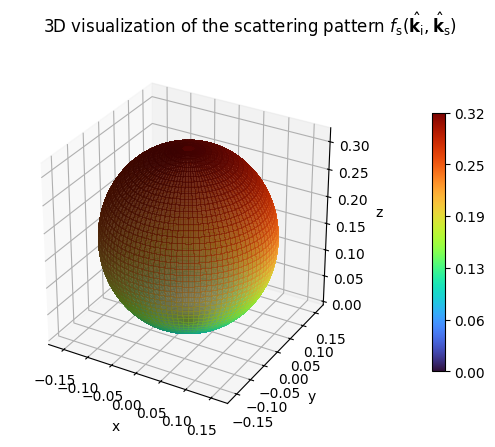

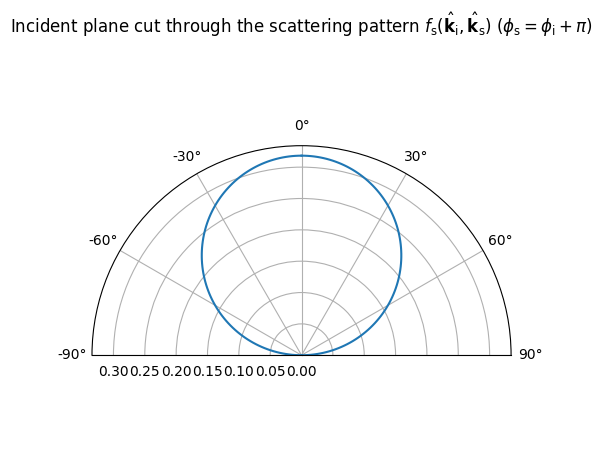

In [4]:
LambertianPattern().visualize();

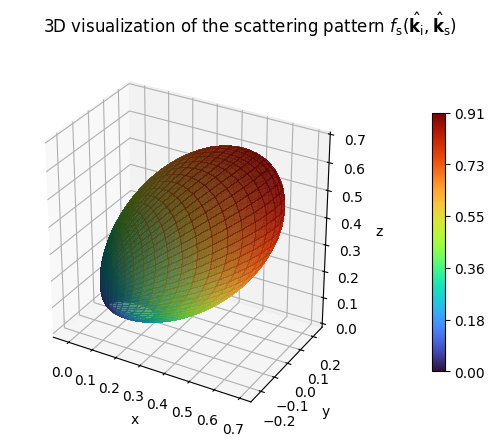

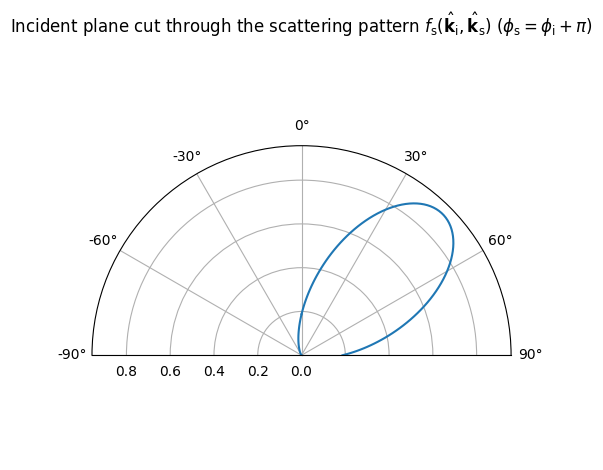

In [5]:
DirectivePattern(alpha_r=10).visualize(); 

In [6]:
scene = load_scene(sionna.rt.scene.simple_reflector)

# Configure the transmitter and receiver arrays
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

# Add a transmitter and receiver with equal distance from the center of the surface
# at an angle of 45 degrees.
dist = 5
d = dist/np.sqrt(2)
scene.add(Transmitter(name="tx", position=[-d,0,d]))
scene.add(Receiver(name="rx", position=[d,0,d]))

# Add a camera for visualization
scene.add(Camera("my_cam", position=[0, -30, 20], look_at=[0,0,3]))

if no_preview:
    scene.render("my_cam");

In [7]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [8]:
paths = scene.compute_paths(los=False, reflection=True)

if no_preview:
    scene.render("my_cam", paths=paths);

In [9]:
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

In [10]:
paths = scene.compute_paths(los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
if no_preview:
    scene.render("my_cam", paths=paths);

In [11]:
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

In [12]:
print(f"There are {tf.size(paths.a).numpy()} scattered paths")

There are 2252 scattered paths


In [13]:
paths = scene.compute_paths(num_samples=2e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
print(f"There are {tf.size(paths.a).numpy()} scattered paths.")

paths = scene.compute_paths(num_samples=10e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
print(f"There are {tf.size(paths.a).numpy()} scattered paths.")

There are 4506 scattered paths.
There are 22563 scattered paths.


In [14]:
paths = scene.compute_paths(num_samples=10e6, los=False, reflection=False, scattering=True, scat_keep_prob=0.001)
print(f"There are {tf.size(paths.a).numpy()} scattered paths.")

There are 20 scattered paths.


In [15]:
print("All scattered paths have zero energy:", np.all(np.abs(paths.a)==0))

All scattered paths have zero energy: True


In [16]:
scene.get("reflector").radio_material.scattering_coefficient = 0.5
paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True)
print("All scattered paths have positive energy:", np.all(np.abs(paths.a)>0))

All scattered paths have positive energy: True


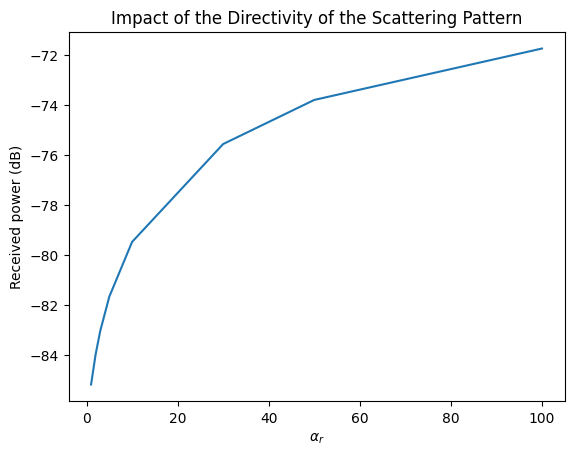

In [17]:
scattering_pattern = DirectivePattern(1)
scene.get("reflector").radio_material.scattering_pattern = scattering_pattern
alpha_rs = np.array([1,2,3,5,10,30,50,100], np.int32)
received_powers = np.zeros_like(alpha_rs, np.float32)
for i, alpha_r in enumerate(alpha_rs):
    scattering_pattern.alpha_r = alpha_r
    paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
    received_powers[i] = 10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))

plt.figure()
plt.plot(alpha_rs, received_powers)
plt.xlabel(r"$\alpha_r$")
plt.ylabel("Received power (dB)");
plt.title("Impact of the Directivity of the Scattering Pattern");

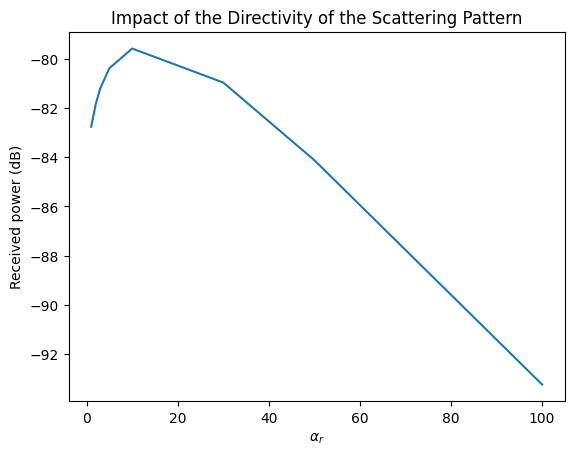

In [18]:
# Move the receiver closer to the surface, i.e., away from the specular angle theta=45deg
scene.get("rx").position = [d, 0, 1]
received_powers = np.zeros_like(alpha_rs, np.float32)
for i, alpha_r in enumerate(alpha_rs):
    scattering_pattern.alpha_r = alpha_r
    paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
    received_powers[i] = 10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))

plt.figure()
plt.plot(alpha_rs, received_powers)
plt.xlabel(r"$\alpha_r$")
plt.ylabel("Received power (dB)");
plt.title("Impact of the Directivity of the Scattering Pattern");

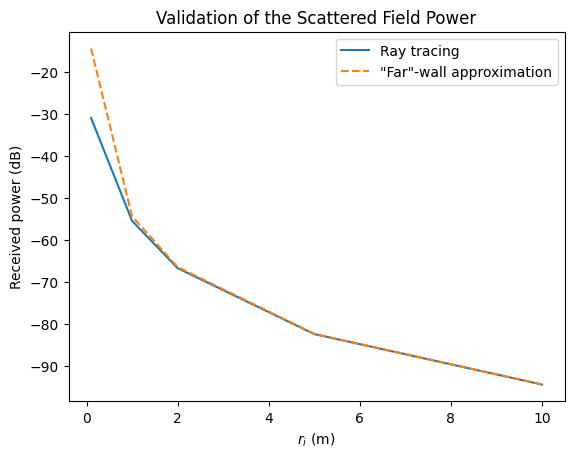

In [19]:
s = 0.7 # Scattering coefficient

# Configure the radio material
scene.get("reflector").radio_material.scattering_pattern = LambertianPattern()
scene.get("reflector").radio_material.scattering_coefficient = s

# Set the carrier frequency
scene.frequency = 3.5e9
wavelength = scene.wavelength

r_is = np.array([0.1, 1, 2, 5, 10], np.float32) # Varying distances
received_powers = np.zeros_like(r_is, np.float32)
theo_powers = np.zeros_like(received_powers)
for i, r_i in enumerate(r_is):
    # Update the positions of TX and RX
    d = r_i/np.sqrt(2)
    scene.get("tx").position = [-d, 0, d]
    scene.get("rx").position = [d, 0, d]
    paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
    received_powers[i] = 10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))

    # Compute theoretically received power using the far-wall approximation
    theo_powers[i] = 10*np.log10((wavelength*s/(4*np.pi*r_i**2))**2/(2*np.pi))

plt.figure()
plt.plot(r_is, received_powers)
plt.plot(r_is, theo_powers, "--")
plt.title("Validation of the Scattered Field Power")
plt.xlabel(r"$r_i$ (m)")
plt.ylabel("Received power (dB)");
plt.legend(["Ray tracing", "\"Far\"-wall approximation"]);